### Input data
The training dataset used in this model can be found in Box at the following location.

`Data Science > Data > features > loan_outcomes_<unix_ts_1>_features_<unix_ts_2>.csv`

In [1]:
import subprocess
import warnings
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap
from sklearn.metrics import log_loss
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier

from lib import pipeline
from lib.decision_diagnostics import (
    find_profit_by_bad_rate,
    make_lift_chart,
    plot_bad_rates,
    plot_loan_dependent_profit,
    profit_from_loan_w_fill_fn,
)
from lib.util import (
    cross_val_and_predict,
    get_null_count_by_feature,
    make_hist_of_days_elapsed,
    make_hist_of_null_features,
    make_loan_term_hist,
    make_overdue_target,
    make_scatter_of_interest_and_principal,
    plot_confusion_matrix,
    preprocess_input_dataset,
    filter_multi_phonenumber_by_uuid,
)

warnings.filterwarnings("ignore")

### Load data and select instances with observed loan outcomes

In [2]:
# Load loan outcome data with features for training.
input_filename = "loan_outcomes_1663898493_features_v0_11_0.csv"
input_df = pd.read_csv(input_filename, dtype={"phone_number": str})

# Define target variable used to determine if a loan has a positive or negative outcome.
input_df["loan_overdue_3"] = make_overdue_target(input_df, 3)

target_value = "loan_overdue_3"


# Define features which should be used for model training.
feature_names = [    
    "average_end_of_day_depository_balance_0_30",
    "average_end_of_day_depository_balance_0_90",
    "average_end_of_day_depository_balance_31_60",
    "average_end_of_day_depository_balance_61_90",
    "average_end_of_day_loan_balance_0_30",
    "average_end_of_day_loan_balance_0_90",
    "average_end_of_day_loan_balance_31_60",
    "average_end_of_day_loan_balance_61_90",
    "count_betting_and_lottery_events_0_30",
    "count_betting_and_lottery_events_0_90",
    "count_betting_and_lottery_events_31_60",
    "count_betting_and_lottery_events_61_90",
    "count_depository_transactions_between_user_accounts_0_30",
    "count_depository_transactions_between_user_accounts_0_90",
    "count_depository_transactions_between_user_accounts_31_60",
    "count_depository_transactions_between_user_accounts_61_90",
    "count_of_accounts_0_90",
    "count_of_accounts_0_30",
    "count_of_accounts_31_60",
    "count_of_accounts_61_90",
    "count_of_institutions_0_90",
    "count_of_institutions_0_30",
    "count_of_institutions_31_60",
    "count_of_institutions_61_90",
    "count_institutions_with_open_loans_0_30",
    "count_institutions_with_open_loans_0_90",
    "count_institutions_with_open_loans_31_60",
    "count_institutions_with_open_loans_61_90",
    "count_insufficient_funds_events_0_30",
    "count_insufficient_funds_events_0_90",
    "count_insufficient_funds_events_31_60",
    "count_insufficient_funds_events_61_90",
    "count_loan_declined_events_0_30",
    "count_loan_declined_events_0_90",
    "count_loan_declined_events_31_60",
    "count_loan_declined_events_61_90",
    "count_loan_defaulted_events_0_30",
    "count_loan_defaulted_events_0_90",
    "count_loan_defaulted_events_31_60",
    "count_loan_defaulted_events_61_90",
    "count_loan_missed_payment_events_0_30",
    "count_loan_missed_payment_events_0_90",
    "count_loan_missed_payment_events_31_60",
    "count_loan_missed_payment_events_61_90",
    "count_loan_opened_events_0_30",
    "count_loan_opened_events_0_90",
    "count_loan_opened_events_31_60",
    "count_loan_opened_events_61_90",
    "count_loan_repayment_events_0_30",
    "count_loan_repayment_events_0_90",
    "count_loan_repayment_events_31_60",
    "count_loan_repayment_events_61_90",
    "count_overdraft_events_0_30",
    "count_overdraft_events_0_90",
    "count_overdraft_events_31_60",
    "count_overdraft_events_61_90",
    "count_user_shared_device_ids_0_10",
    "count_user_shared_phone_numbers_0_10",
    "daily_average_of_stacked_loan_alerts_0_90",
    "daily_average_of_stacked_loan_fes_0_90",
    "data_density_0_30",
    "data_density_0_90",
    "data_density_31_60",
    "data_density_61_90",
    "days_since_largest_credit_0_30",
    "days_since_largest_credit_0_90",
    "days_since_largest_credit_31_60",
    "days_since_largest_credit_61_90",
    "loan_sharks_alert_institutions_ratio_0_90",
    "loan_sharks_fes_ratio_0_90",
    "median_end_of_day_depository_balance_0_30",
    "median_end_of_day_depository_balance_0_90",
    "median_end_of_day_depository_balance_31_60",
    "median_end_of_day_depository_balance_61_90",
    "min_end_of_day_depository_balance_0_30",
    "min_end_of_day_depository_balance_0_90",
    "min_end_of_day_depository_balance_31_60",
    "min_end_of_day_depository_balance_61_90",
    "net_cash_flow_0_30",
    "net_cash_flow_0_90",
    "net_cash_flow_31_60",
    "net_cash_flow_61_90",
    "ratio_of_count_of_credits_to_debits_depository_transactions_0_30",
    "ratio_of_count_of_credits_to_debits_depository_transactions_0_90",
    "ratio_of_count_of_credits_to_debits_depository_transactions_31_60",
    "ratio_of_count_of_credits_to_debits_depository_transactions_61_90",
    "ratio_of_loan_defaulted_to_loan_opened_events_0_90",
    "ratio_of_loan_defaulted_to_loan_opened_events_0_30",
    "ratio_of_loan_defaulted_to_loan_opened_events_31_60",
    "ratio_of_loan_defaulted_to_loan_opened_events_61_90",
    "ratio_of_loan_repaid_to_loan_approved_events_0_30",
    "ratio_of_loan_repaid_to_loan_approved_events_0_90",
    "ratio_of_loan_repaid_to_loan_approved_events_31_60",
    "ratio_of_loan_repaid_to_loan_approved_events_61_90",
    "slope_end_of_day_depository_balance_0_90",
    "slope_end_of_day_loan_balance_0_90",
    "stdev_end_of_day_depository_balance_0_30",
    "stdev_end_of_day_depository_balance_0_90",
    "stdev_end_of_day_depository_balance_31_60",
    "stdev_end_of_day_depository_balance_61_90",
    "sum_of_credits_0_30",
    "sum_of_credits_0_90",
    "sum_of_credits_31_60",
    "sum_of_credits_61_90",
    "sum_of_debits_0_30",
    "sum_of_debits_0_90",
    "sum_of_debits_31_60",
    "sum_of_debits_61_90",
    "sum_of_depository_balances_latest",
    "sum_of_depository_transactions_between_user_accounts_0_30",
    "sum_of_depository_transactions_between_user_accounts_0_90",
    "sum_of_depository_transactions_between_user_accounts_31_60",
    "sum_of_depository_transactions_between_user_accounts_61_90",
    "sum_of_loan_repayments_0_30",
    "sum_of_loan_repayments_0_90",
    "sum_of_loan_repayments_31_60",
    "sum_of_loan_repayments_61_90",
    "time_average_credits_0_90",
    "time_average_debits_0_90",
    "time_average_net_cash_flow_0_90",
    "transactions_per_day_depository_0_90",
    "transactions_per_day_loan_0_90",
]

df = preprocess_input_dataset(
    df_in=input_df,
    institutions=institutions,
    target_value=target_value,
    drop_duplicate_pn_decision_date=True,
)

spread of loan_overdue_3 among loan instances: 
 False    26663
True     11316
Name: loan_overdue_3, dtype: int64
total count of loan instances post filtering: 37979


### Impute missing data

In [5]:
time_average_imputer = pipeline.TimeAverageImputer()
zero_imputer = pipeline.ValueImputer(
    value=0,
    features=[
        "average_end_of_day_depository_balance_0_30",
        "average_end_of_day_depository_balance_0_90",
        "average_end_of_day_depository_balance_31_60",
        "average_end_of_day_depository_balance_61_90",
        "average_end_of_day_loan_balance_0_30",
        "average_end_of_day_loan_balance_0_90",
        "average_end_of_day_loan_balance_31_60",
        "average_end_of_day_loan_balance_61_90",
        "count_betting_and_lottery_events_0_30",
        "count_betting_and_lottery_events_0_90",
        "count_betting_and_lottery_events_31_60",
        "count_betting_and_lottery_events_61_90",
        "count_depository_transactions_between_user_accounts_0_30",
        "count_depository_transactions_between_user_accounts_0_90",
        "count_depository_transactions_between_user_accounts_31_60",
        "count_depository_transactions_between_user_accounts_61_90",
        "count_institutions_with_open_loans_0_30",
        "count_institutions_with_open_loans_0_90",
        "count_institutions_with_open_loans_31_60",
        "count_institutions_with_open_loans_61_90",
        "count_insufficient_funds_events_0_30",
        "count_insufficient_funds_events_0_90",
        "count_insufficient_funds_events_31_60",
        "count_insufficient_funds_events_61_90",
        "count_loan_declined_events_0_30",
        "count_loan_declined_events_0_90",
        "count_loan_declined_events_31_60",
        "count_loan_declined_events_61_90",
        "count_loan_defaulted_events_0_30",
        "count_loan_defaulted_events_0_90",
        "count_loan_defaulted_events_31_60",
        "count_loan_defaulted_events_61_90",
        "count_loan_missed_payment_events_0_30",
        "count_loan_missed_payment_events_0_90",
        "count_loan_missed_payment_events_31_60",
        "count_loan_missed_payment_events_61_90",
        "count_loan_opened_events_0_30",
        "count_loan_opened_events_0_90",
        "count_loan_opened_events_31_60",
        "count_loan_opened_events_61_90",
        "count_loan_repayment_events_0_30",
        "count_loan_repayment_events_0_90",
        "count_loan_repayment_events_31_60",
        "count_loan_repayment_events_61_90",
        "count_of_accounts_0_30",
        "count_of_accounts_0_90",
        "count_of_accounts_31_60",
        "count_of_accounts_61_90",
        "count_of_institutions_0_30",
        "count_of_institutions_0_90",
        "count_of_institutions_31_60",
        "count_of_institutions_61_90",
        "count_overdraft_events_0_30",
        "count_overdraft_events_0_90",
        "count_overdraft_events_31_60",
        "count_overdraft_events_61_90",
        "ratio_of_loan_defaulted_to_loan_opened_events_0_30",
        "ratio_of_loan_defaulted_to_loan_opened_events_0_90",
        "ratio_of_loan_defaulted_to_loan_opened_events_31_60",
        "ratio_of_loan_defaulted_to_loan_opened_events_61_90",
        "slope_end_of_day_depository_balance_0_90",
        "slope_end_of_day_loan_balance_0_90",
    ]
)
one_imputer = pipeline.ValueImputer(
    value=1,
    features=[
        "ratio_of_count_of_credits_to_debits_depository_transactions_0_30",
        "ratio_of_count_of_credits_to_debits_depository_transactions_0_90",
        "ratio_of_count_of_credits_to_debits_depository_transactions_31_60",
        "ratio_of_count_of_credits_to_debits_depository_transactions_61_90",
        "ratio_of_loan_repaid_to_loan_approved_events_0_30",
        "ratio_of_loan_repaid_to_loan_approved_events_0_90",
        "ratio_of_loan_repaid_to_loan_approved_events_31_60",
        "ratio_of_loan_repaid_to_loan_approved_events_61_90",
    ]
)

In [7]:
# Remove rows containing missing data which we could not impute.
is_addressable = ~X.isna().any(axis=1)
X = X.loc[is_addressable, :]
y = y.loc[is_addressable]

print(f"count of loan instances post imputation: {len(X)}")


count of loan instances post imputation: 37068


### Define model evaluation utilities

In [8]:
from typing import Callable, Tuple, Type


def evaluate_pipeline(
    estimator_in: Pipeline,
    X_in: pd.DataFrame,
    y_in: pd.Series,
    loan_instances: pd.DataFrame,
    profit_fn: Callable[..., float],
    explainer_cls: Type[shap.Explainer] = shap.Explainer
) -> Tuple[np.ndarray, Pipeline]:
    """
    Run a suite of cross-validation & explainability tools/plots for a given
    estimator and input dataset.
    :param estimator_in: sklearn pipeline or equivalent
    :param X_in: input feature tensor
    :param y_in: input target vector
    :param loan_instances: dataframe with all the loan instance information
    :param profit_fn: function used in conjunction with loan instances to model profit
    :param explainer_cls: explainer to use for shap
    """
    #  indexing on X_in and y_in must match, and must be subsets of loan_instances;
    if not X_in.index.equals(y_in.index):
        raise ValueError("X_in and y_in df indices do not match")
    elif not X_in.index.isin(loan_instances.index).any():
        raise ValueError("loan_instances df does not contain X_in indices")
    elif not y_in.index.isin(loan_instances.index).any():
        raise ValueError("loan_instances df does not contain y_in indices")

    # calculate + print mean cross-val auc
    cv = KFold(n_splits=10, random_state=0, shuffle=True)
    cv_y_predict, _ = cross_val_and_predict(estimator_in, X_in, y_in, cv)

    loss = log_loss(y_in, cv_y_predict)
    print(f"Log loss: {loss:.3}")

    # plot lift chart
    make_lift_chart(cv_y_predict, y_in)
    plot_bad_rates(cv_y_predict, y_in)

    # plot loan-dependent profit curve
    profit_by_bad_rate = find_profit_by_bad_rate(
        predicted=cv_y_predict,
        actual=y_in,
        loan_instances=loan_instances,
        target=target_value,
        profit_from_loan_fn=profit_fn,
    )
    perc_risk_max_profit = plot_loan_dependent_profit(
        profit_by_bad_rate=profit_by_bad_rate,
        plot_loan_volumes=True
    )

    # plot confusion matrix at maximum modelled profit
    plot_confusion_matrix(y_in, cv_y_predict, perc_risk_max_profit/100.)

    # generate permutation importance & beeswarms
    fitted_model = estimator_in.fit(X_in, y_in)
    explainer = explainer_cls(model=fitted_model.predict, masker=X_in)
    shap_vals = explainer(X_in.sample(500, random_state=0))
    plt.figure()
    shap.plots.bar(shap_vals, max_display=45)
    plt.figure()
    shap.plots.beeswarm(shap_vals, max_display=45)

    return cv_y_predict, fitted_model


profit_from_loan_fn = partial(
    profit_from_loan_w_fill_fn,
    loss_fraction=0.5,  # N% loss rate for "bad" loans
    recovery_period_days=90, # recovered loans over N days
    value_fill = {"loan_amount": 2250, "loan_interest": 25}
)

## XGBoost

mean CV AUC: 0.73 +- 0.02 (2σ)
Log loss: 0.542
loan-dependent profit curve. Max net profit of: 0.0 at threshold: 0.0%, with count of approved loans: 0 (0.0% of total)


Permutation explainer: 501it [01:44,  4.38it/s]                         


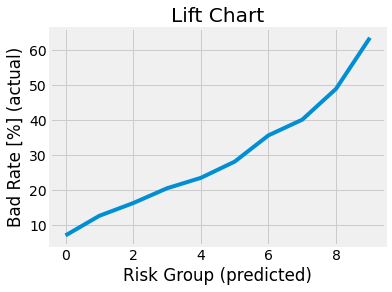

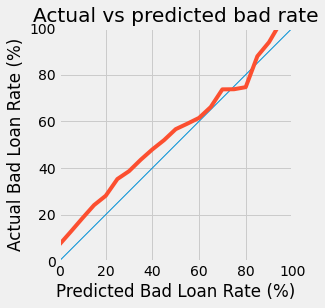

<Figure size 432x288 with 0 Axes>

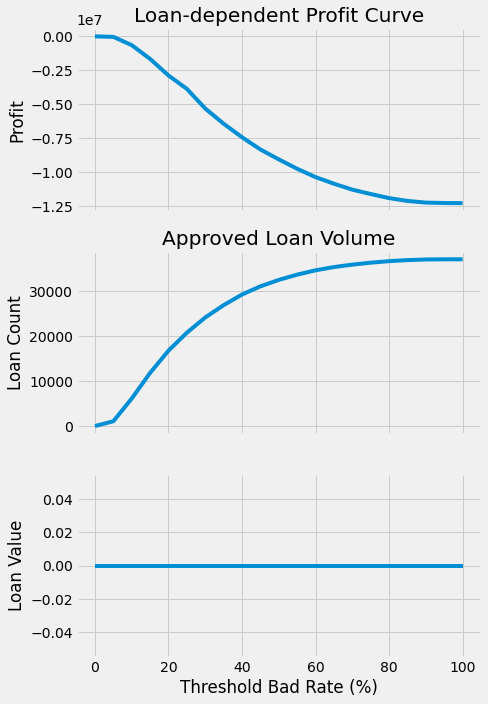

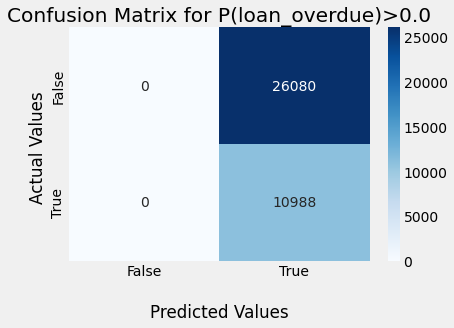

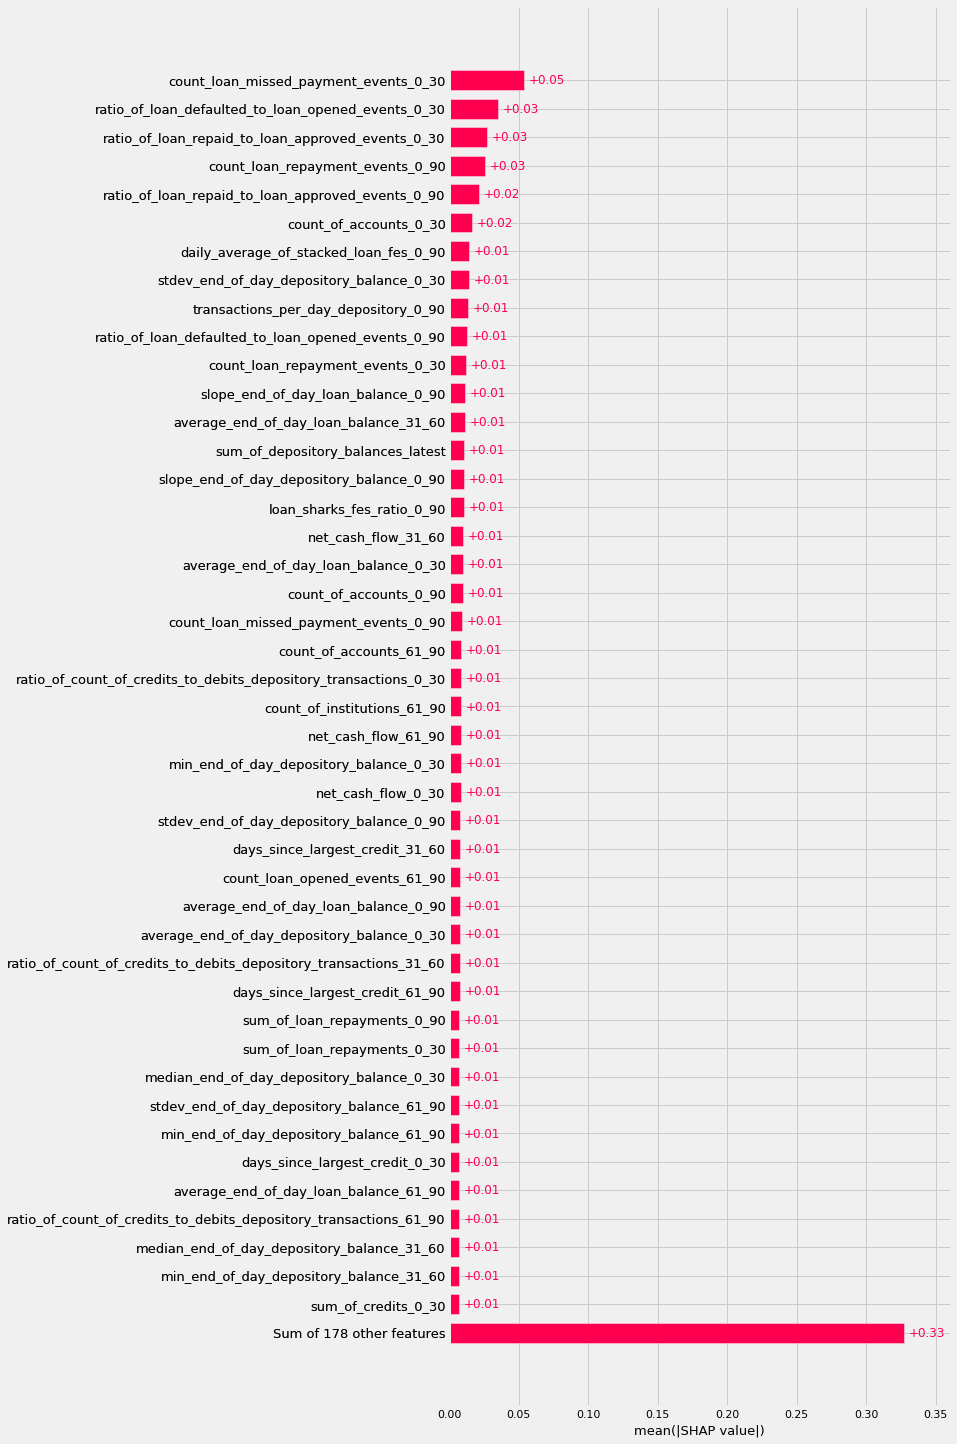

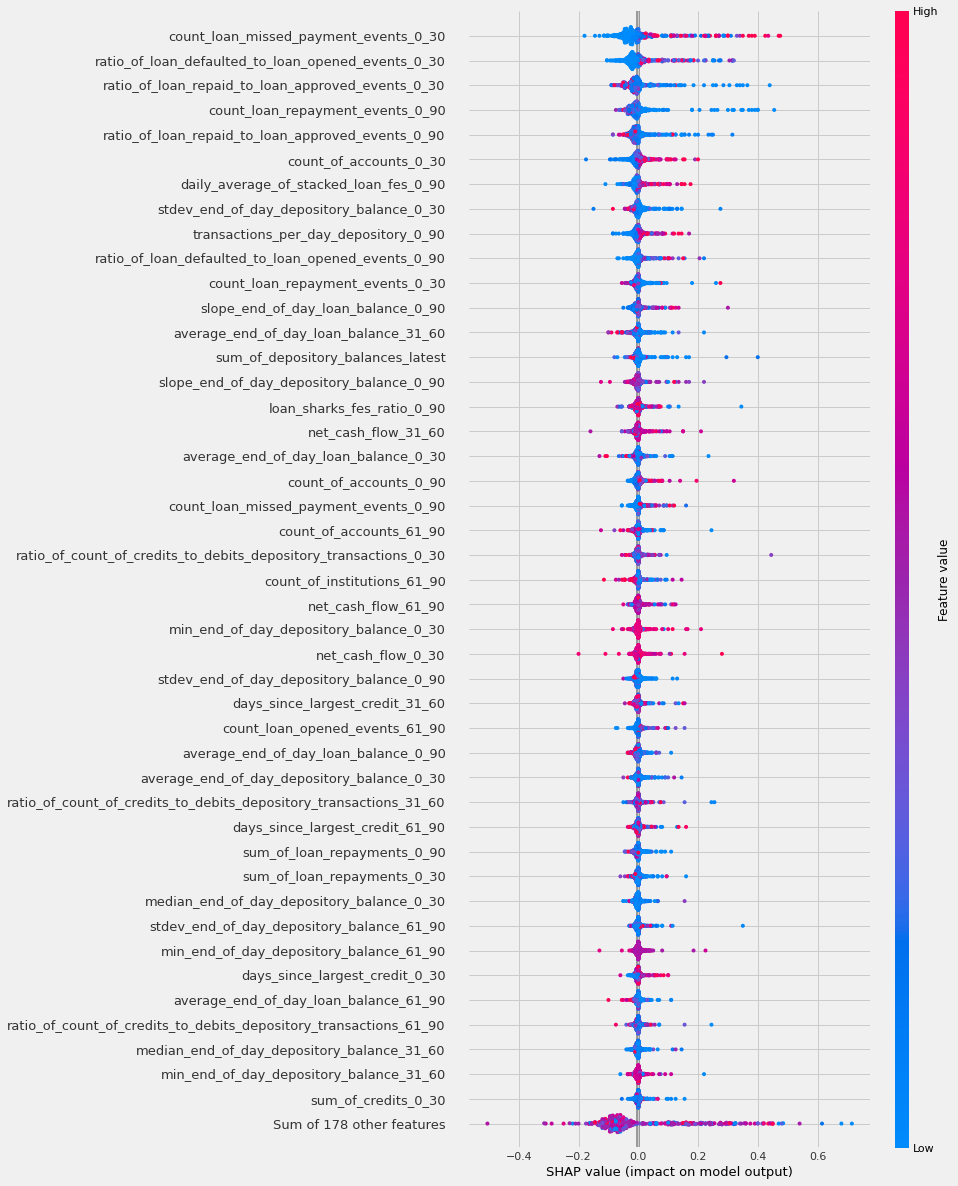

In [10]:
# Optimal hyperparams from grid search in prev cell.
xgb_classifier = XGBClassifier(
    n_estimators=500,
    max_depth=14,
    learning_rate=0.01,
    subsample=0.5,
    random_state=0,
    n_jobs=-1,
)

xgb_pipeline = Pipeline([("model", xgb_classifier)])

y_predict, model = evaluate_pipeline(xgb_pipeline, X, y, df, profit_from_loan_fn)

